<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Decision_tree_tutorial_white_wine_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decision Tree**
---
A decision tree is one of the popular and powerful machine learning algorithms that I have learned. It is a non-parametric supervised learning method that can be used for both classification and regression tasks. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision tree algorithm uses Information Gain to decide the splitting points. In order to measure how much information we gain, we can use entropy to calculate the homogeneity of a sample. **Entropy** is a measure of the amount of uncertainty in a data set. Entropy controls how a Decision Tree decides to split the data. It actually affects how a Decision Tree draws its boundaries.

We can summarize the ID3 algorithm as illustrated below:

1. Compute the entropy for data-set **Entropy(D)**
    - Calculate **Entropy** (Amount of uncertainity in dataset):
$$Entropy(D) = \frac{-p}{p+n}log_{2}(\frac{p}{p+n}) - \frac{n}{p+n}log_{2}(\frac{n}{p+n})$$
    
2. For every attribute/feature:
    - Calculate entropy for all other values **Entropy(A)**
             
    - Take **Average Information Entropy** for the current attribute
        - Calculate **Average Information**:
    $$Entropy(S) = \sum\frac{p_{i}+n_{i}}{p+n}Entropy(A)$$  
    
    - Calculate **Gain** for the current attribute
        - Calculate **Information Gain**: (Difference in Entropy before and after splitting dataset on attribute A)        
$$Gain = Entropy(D) - Entropy(S)$$

3. Pick the **Highest Gain Attribute**.
4. **Repeat** until we get the tree we desired.

#### **Compute Entropy**

In [1]:
import math

def entropy(value):
    from collections import Counter

    total_instances = len(value)
    cnt = Counter(x for x in value)
    probs = [x / total_instances for x in cnt.values()]
    E = sum([-prob * math.log(prob, 2) for prob in probs])
    return E

#### **Compute Information Gain**

In [2]:
def information_gain(df, feature, target):
	df_split = df.groupby(feature)
	glist = []
	for gname, group in df_split:
		glist.append(gname)

	glist.reverse()
	nobs = len(df.index) * 1.0

	df_agg1 = df_split.agg({target: lambda x:entropy(x)})
	df_agg1.columns = ['Entropy']

	df_agg2 = df_split.agg({target: lambda x:len(x)/nobs})
	df_agg2.columns = ['Proportion']

	EA = sum(df_agg1['Entropy'] * df_agg2['Proportion'])
	ED = entropy(df[target])

	return ED - EA

#### **Building the Decision Tree**

In [3]:
def DT(df, feature, target, default_class=None):

    from collections import Counter
    cnt = Counter(x for x in df[target])

    if len(cnt) == 1:
        return next(iter(cnt))

    elif df.empty or (not feature):
        return default_class

    else:
        default_class = max(cnt.keys())
        gainz = []
        for attr in feature:
            ig = information_gain(df, attr, target)
            gainz.append(ig)

        index_of_max = gainz.index(max(gainz))
        best_attr = feature[index_of_max]
        tree = {best_attr:{}}
        remaining_attribute_names = [i for i in feature if i != best_attr]

        for attr_val, data_subset in df.groupby(best_attr):
            subtree = DT(data_subset, remaining_attribute_names, target, default_class)
            tree[best_attr][attr_val] = subtree
        return tree

#### **Classify New Data Point**

In [4]:
def classify(instance, tree, default=None):

    feature = next(iter(tree))
    if instance[feature] in tree[feature].keys():
        result = tree[feature][instance[feature]]
        if isinstance(result, dict):
            return classify(instance, result)
        else:
            return result
    else:
        return default

In [5]:
# Importing libraries and loading dataset
import seaborn as sns
import pandas as pd

# Example for titanic dataset
data = sns.load_dataset('titanic')
data.loc[:, 'age'] =  data['age'].fillna(data['age'].median())

# Applying to Predicted column
tree = DT(data, feature=['pclass', 'sex', 'age', 'fare'], target='survived')
data['Predicted'] = data.apply(classify, axis=1, args=(tree, '?'))
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Predicted
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0


In [6]:
# data summary
data.shape

(891, 16)

#### **Building a Decision Tree using** `scikit-learn`

**Importing Libraries**

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### `Business Problem Understanding`

**Problem Statement**

Because tip amounts vary, determining an appropriate tip is crucial for employee well-being.

**Goals**

Determine the appropriate tip amount for each customer.

**Analytic Approach**

So, what we need to do is analyze the data to find patterns in the existing features that differentiate one customer from another.

Next, we will build a regression model that will help the company provide a tip prediction tool for new customers, which will be useful for improving employee well-being.

**Metric Evaluation**

The evaluation metrics that will be used are MAE and MSE. The smaller the value of these two, the more accurate the model is in predicting tip amounts, based on the limitations of the features used.

Furthermore, we can also calculate the R-squared or adj. R-squared value to determine how well the model represents the overall variance of the data. The closer it is to 1, the better the model fits the observed data. However, this metric is not valid for non-linear models.

In [8]:
# Loading dataset
white_wine_csv = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/white_wine.csv'
data = pd.read_csv(white_wine_csv)
print(f'Number of rows and columns: {data.shape}')

data.head()

Number of rows and columns: (520, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [9]:
# Checking dataset
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'min': data.min().values,
    'max': data.max().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,min,max,sample_unique
0,fixed acidity,float64,0.000000,False,41,5.0000,10.2000,"[7.0, 6.3, 8.1, 7.2, 6.2, 8.6, 7.9, 6.6, 8.3, ..."
1,volatile acidity,float64,0.000000,False,69,0.1000,0.9050,"[0.27, 0.3, 0.28, 0.23, 0.32, 0.22, 0.18, 0.16..."
2,citric acid,float64,0.000000,False,59,0.0000,0.8800,"[0.36, 0.34, 0.4, 0.32, 0.16, 0.43, 0.41, 0.37..."
3,residual sugar,float64,0.000000,False,160,0.8000,22.0000,"[20.7, 1.6, 6.9, 8.5, 7.0, 1.5, 1.45, 4.2, 1.2..."
4,chlorides,float64,0.000000,False,67,0.0200,0.3460,"[0.045, 0.049, 0.05, 0.058, 0.044, 0.033, 0.03..."
5,free sulfur dioxide,float64,0.000000,False,81,3.0000,131.0000,"[45.0, 14.0, 30.0, 47.0, 28.0, 11.0, 17.0, 16...."
6,total sulfur dioxide,float64,0.000000,False,168,41.0000,313.0000,"[170.0, 132.0, 97.0, 186.0, 136.0, 129.0, 63.0..."
7,density,float64,0.000000,False,100,0.9899,1.0033,"[1.001, 0.994, 0.9951, 0.9956, 0.9949, 0.9938,..."
8,pH,float64,0.192308,False,69,2.8700,3.7200,"[3.0, 3.3, 3.26, 3.19, 3.18, 3.22, 2.99, 3.14,..."
9,sulphates,float64,0.192308,False,54,0.2700,0.8500,"[0.45, 0.49, 0.44, 0.4, 0.47, 0.56, 0.53, 0.63..."


**Insight**

- The dataset consists of 520 rows and 12 columns.
- All variables are numeric and continuous, except for quality, which is discrete.
- The data format for the quality variable should be integer.
- The scale of the total sulfur dioxide and free sulfur dioxide variables is larger than the others.

### `Data Preparation`

In [10]:
df = data[['alcohol', 'density', 'quality']].copy()
df.sample(5)

,alcohol,density,quality
122,9.7,0.9952,5.0
462,9.5,0.9973,5.0
336,11.2,0.9910,6.0
427,9.4,0.9974,5.0
341,10.0,0.9948,6.0


`Duplicates`

In [12]:
print(f"Number of duplicate data: {df[df.duplicated()].shape}")
print(f'Percentage of duplicate data: {df.duplicated().sum()/len(df)*100:.2f}')

Number of duplicate data: (115, 3)
Percentage of duplicate data: 22.12


As much as 22% of the data is indicated as duplicate, so remove one of them.

Handling duplicated data

In [13]:
df.drop_duplicates(keep='last', inplace=True, ignore_index=True)

`Missing Values`

Quantifying missing values

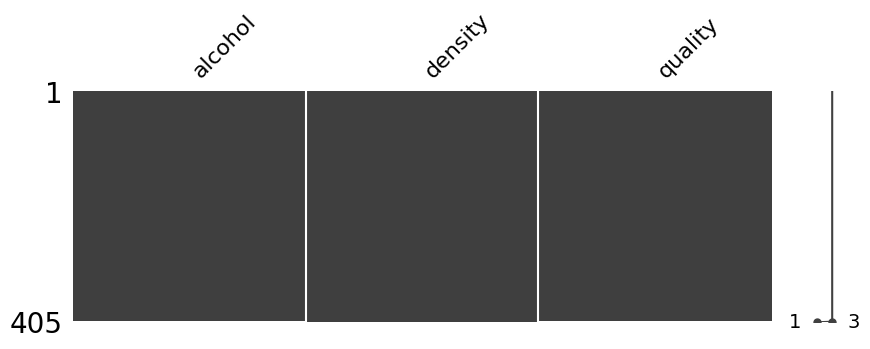

In [16]:
import missingno as msn

msn.matrix(df, figsize=(10,3))
plt.show()

In [15]:
pd.DataFrame({'missing values': [df[col].isna().sum() for col in df.columns]}, index=df.columns.values)

,missing values
alcohol,1
density,0
quality,1


Handling missing values

In [17]:
df.dropna(inplace=True)

`Rare Labels`

Rare value detection and quantification

In [18]:
pd.DataFrame(df['quality'].value_counts(normalize=True) * 100).round(2)

,proportion
quality,
6.0,45.05
5.0,31.44
7.0,15.10
4.0,4.21
8.0,3.22
3.0,0.99


More than 50% is dominated by wines with a quality of more than 6.

Handling rare value

In [19]:
import numpy as np

df['quality'] = df['quality'].apply(lambda x: np.where(x > 6, 1, 0))

`Outliers`

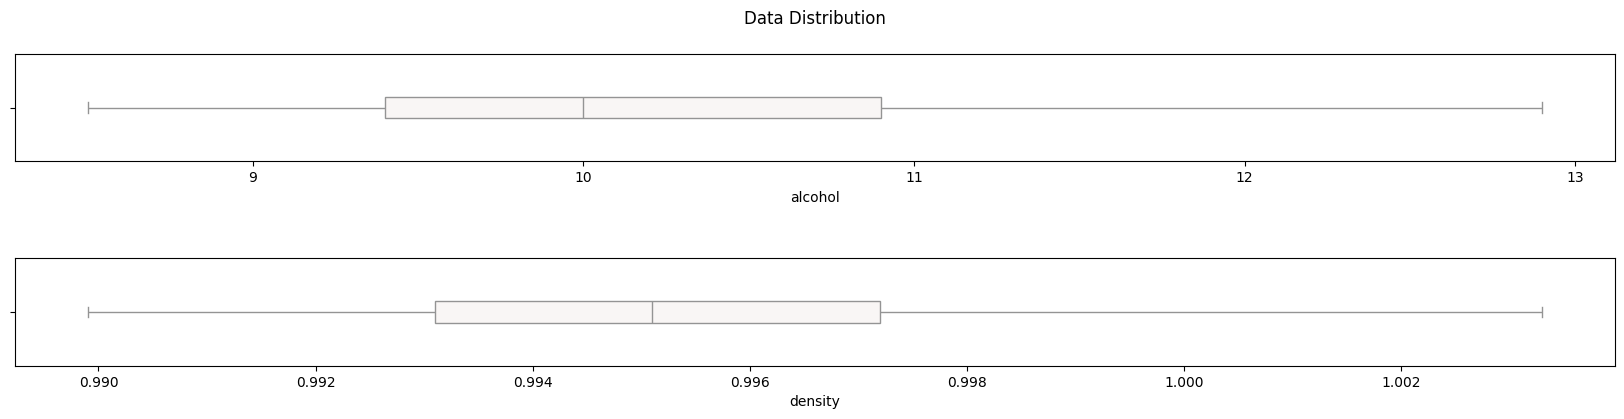

In [22]:
# Display boxplot to show outliers
fig, ax = plt.subplots(2, 1, figsize=(20, 4))

sns.boxplot(x='alcohol', data=df, width=.2, palette="vlag", ax=ax[0])
sns.boxplot(x='density', data=df, width=.2, palette="vlag", ax=ax[1])

ax[0].set_title("Data Distribution", y=1.2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, wspace=0.1, hspace=0.9)
plt.show()

In [23]:
# Perform iqr for outlier detection

Q1 = df['density'].quantile(0.25)
Q3 = df['density'].quantile(0.75)
IQR = Q3 - Q1

n_outlier = df['density'] >= (Q3 + 1.5*IQR)
df[n_outlier].shape

(0, 3)

There are no outliers in the density variable.

`Imbalance Data`

Detection and quantification of target label proportion

In [24]:
df['quality'].value_counts(normalize=True) * 100

,proportion
quality,
0,81.683168
1,18.316832


The data displays imbalance. The percentage of label 0 (81.6%) is more than label 1 (18.2%).

`Check Multicollinearity`

Detecting multicollinearity between features with VIF.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(columns='quality')
y = df['quality']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] =  X.columns

vif.round(2)

,VIF Factor,Feature
0,88.56,alcohol
1,88.56,density


There is multicollinearity between the alcohol and density features. When using a linear model, multicollinearity should be avoided. However, for this case study, we will maintain those features.

**Feature Engineering**

Split the dataset into a train and test set.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

X_train.shape, X_test.shape

((282, 2), (122, 2))

### `Model Experiment`

Setting basic parameters to initialize the experiment and create a transformation pipeline

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['alcohol', 'density'])
], remainder='passthrough')

# fit and transform
X_train_scale = transformer.fit_transform(X_train)
X_test_scale = transformer.transform(X_test)

**Benchmark Model**

`Without Scaling`

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the model
estimator = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)

# Fitting the model
estimator.fit(X_train, y_train)

# Predict to test set
y_pred_test = estimator.predict(X_test)

# Evaluate score
accuracy_score(y_test, y_pred_test)

0.9426229508196722

`With Scaling`

In [29]:
# Define the model
estimator = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)

# Fitting the model
estimator.fit(X_train_scale, y_train)

# Predict to test set
y_pred_test = estimator.predict(X_test_scale)

# Evaluate score
accuracy_score(y_test, y_pred_test)

0.9426229508196722

- Actually, Decision Tree does not requires scaling

**Model Selection**

In [30]:
# Declare list to hold a result
training_accuracies = []
testing_accuracies = []

# Specify the number of depth iteration
depth = range(1, 20)

for i in depth:

    # define model
    estimator = DecisionTreeClassifier(max_depth=i, criterion='entropy', random_state=42)

    # fitting model
    estimator.fit(X_train, y_train)

    # predict to test set and train set
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)

    # calculate accuracy score
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # store in list
    training_accuracies.append(accuracy_train)
    testing_accuracies.append(accuracy_test)

# Compile the result
pd.DataFrame({
    'Depth': [i for i in depth],
    'Training': training_accuracies,
    'Testing': testing_accuracies
}).sort_values(['Testing', 'Training'], ascending=False)


,Depth,Training,Testing
8,9,0.992908,0.983607
7,8,0.989362,0.983607
6,7,0.982270,0.983607
9,10,0.996454,0.975410
10,11,0.996454,0.975410
11,12,0.996454,0.975410
12,13,0.996454,0.975410
13,14,0.996454,0.975410
14,15,0.996454,0.975410
15,16,0.996454,0.975410


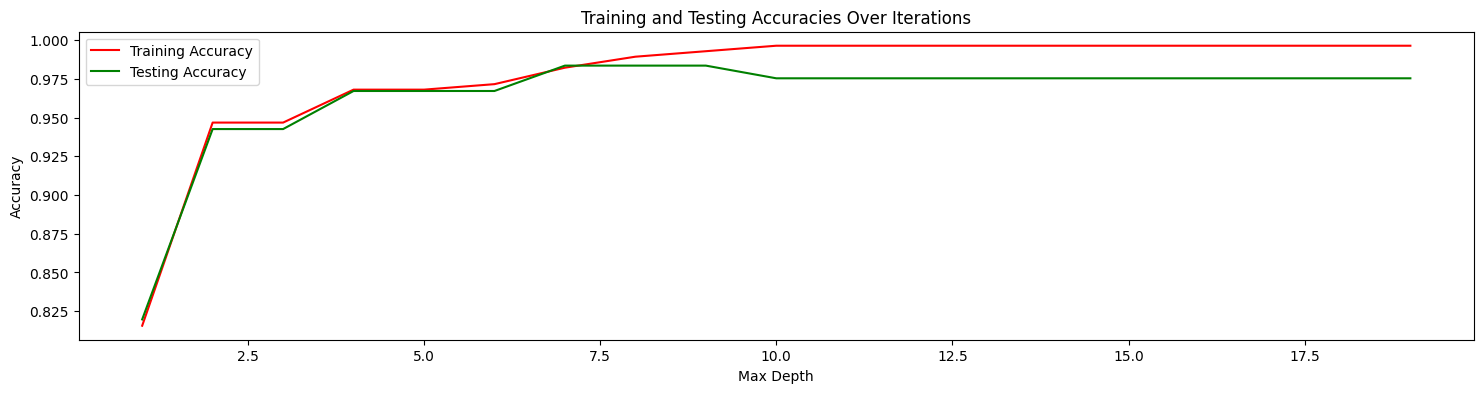

In [31]:
plt.figure(figsize=(18, 4))
plt.plot(depth, training_accuracies, label='Training Accuracy', c='red')
plt.plot(depth, testing_accuracies, label='Testing Accuracy', c='green')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Iterations')
plt.legend()
plt.show()

**Insight**

- A larger max_depth value results in a more stable model. This makes the model less susceptible to noise in the data.

- A larger max_depth value can reduce model bias, but increases the variance of the classification results. This is because the model can more easily distinguish between classes in regions with diverse data points.

- As max_depth increases, the complexity and computational time for making predictions also increase, because the algorithm must consider more factors to generate decision rules.

**Final Model**

In [32]:
best_estimator = DecisionTreeClassifier(max_depth=9, criterion='entropy', random_state=42)
best_estimator.fit(X_train, y_train)

y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

print(f'Model accuracy score in train set: {accuracy_score(y_train, y_pred_train)}')
print(f'Model accuracy score in test set: {accuracy_score(y_test, y_pred_test)}')


Model accuracy score in train set: 0.9929078014184397
Model accuracy score in test set: 0.9836065573770492


**Model Interpretation**

- Accuracy on the test set: 98.36%
- The Decision Tree model was able to correctly predict wine quality (both Good and Bad) 98.36% of the time.
- Of the 122 bottles of wine, 120 were correctly labeled.

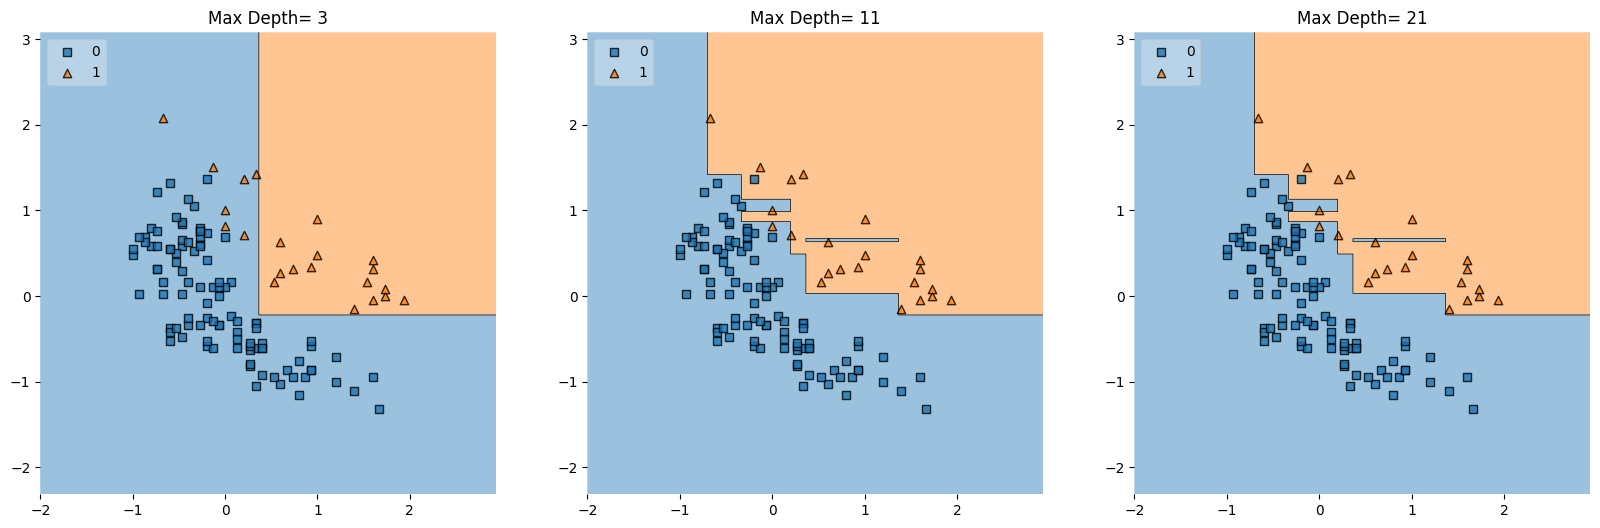

In [33]:
from mlxtend.plotting import plot_decision_regions

# Assuming X has only two features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for id, depth in enumerate([3, 11, 21]):

    # define model
    estimator = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)

    # fitting model
    estimator.fit(X_train_scale, y_train)

    # Set title
    axes[id].set_title(f'Max Depth= {depth}')

    # Plot the decision boundaries
    plot_decision_regions(X_test_scale, y_test.to_numpy(), clf=estimator, legend=2, ax=axes[id])

# Show the plot
plt.show()

**Insight**

A large max_depth value causes the decision boundary to be more sensitive to small variations in the data. This improves classification accuracy but can potentially lead to overfitting due to the increased influence of noisy data points.

`Plot Tree`

In [34]:
# For training purposes we will use max_depth=2

best_estimator = DecisionTreeClassifier(max_depth=9, criterion='entropy', random_state=42)
best_estimator.fit(X_train, y_train)

y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

print(f'Model accuracy score in train set: {accuracy_score(y_train, y_pred_train)}')
print(f'Model accuracy score in test set: {accuracy_score(y_test, y_pred_test)}')


Model accuracy score in train set: 0.9929078014184397
Model accuracy score in test set: 0.9836065573770492


In [35]:
y_train.value_counts()

,count
quality,
0,230
1,52


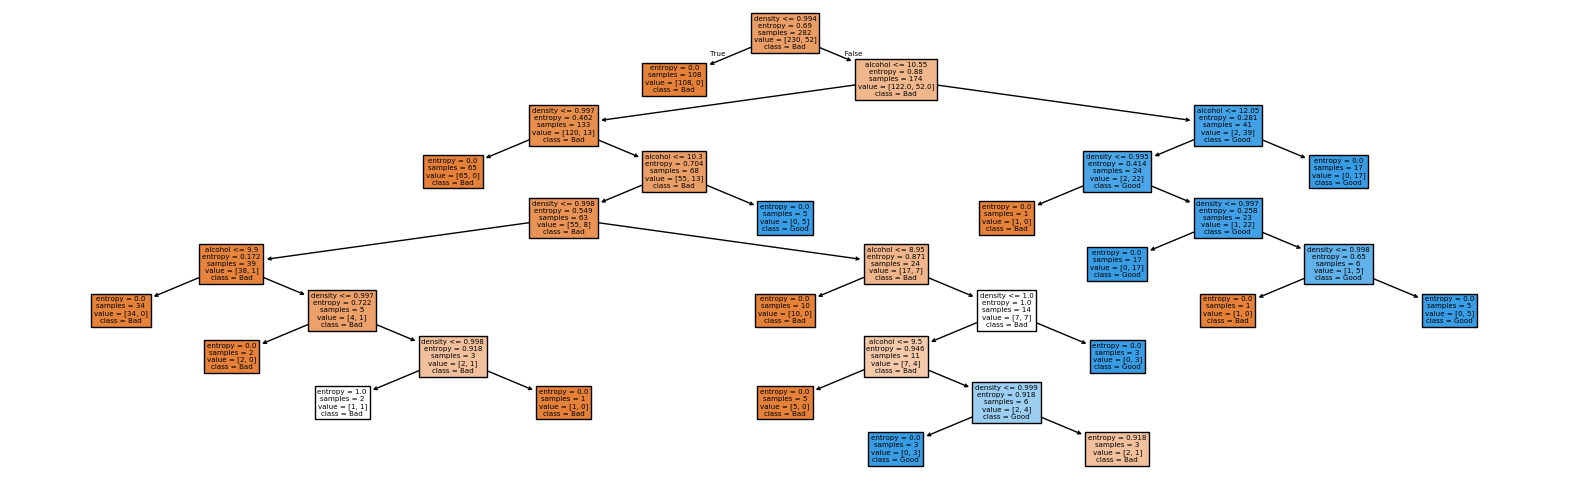

In [36]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20, 6))

_ = plot_tree(
    decision_tree=best_estimator,
    feature_names=['alcohol', 'density'],
    filled=True,
    class_names=['Bad', 'Good']
)

**Insight**

- The alcohol feature is called the root node. This node represents the entire dataset because it contains the rule that best divides the data into two or more subsets. This feature is selected to maximize information gain or minimize impurity.

- Internal nodes in the tree represent decision points. Each internal node contains an IF-THEN rule based on a specific feature and threshold. Internal nodes branch and end at a leaf node. Each leaf node is associated with a class label in the classification task.

- The tree depth is 7 levels, calculated from the root layer to the deepest leaf. Deeper trees can capture more complex relationships in the data but are also susceptible to overfitting.

`Feature Importances`

alcohol: 0.579
density: 0.421


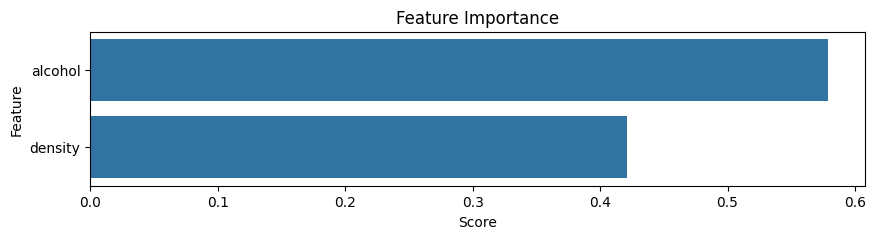

In [37]:
importances = np.round(best_estimator.feature_importances_, 3)

# Get feature names
feature_names = ['alcohol', 'density']

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f'{feature}: {importance}')

# Set figure size
fig, ax = plt.subplots(figsize=(10, 2))

# Plot feature importances
sns.barplot(y=feature_names, x=importances)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Show the plot
plt.show()

**Insight**

Decision tree menentukan splitter dengan memaksimalkan information gain (penurunan impurity), dengan menghitung rerata penurunan impuritas untuk setiap fitur terhadap keseluruhan pohon akan memperoleh skor feature importance. Jadi, berdasarkan grafik di atas, fitur alcohol menjadi yang terpenting dengan rerata penurunan impuritas 0.571, diikuti dengan fitur kandungan density yaitu 0.429.

**Predict to New Data**

In [38]:
new_data = pd.DataFrame({
    'alcohol' : [9, 10, 11],
    'density': [0.990, 0.995, 1],
})

new_data

,alcohol,density
0,9,0.990
1,10,0.995
2,11,1.000


In [39]:
# predict to new data
best_estimator.predict(new_data)

array([0, 0, 1])